### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, IntSlider, FloatSlider, Dropdown, interactive_output
from IPython.display import display
from tqdm import tqdm
import matplotlib.animation as animation


In [2]:

# libraries for quatification
from scipy.ndimage import sobel
from skimage.measure import shannon_entropy, label
from scipy.signal import correlate2d
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import os

import seaborn as sns

from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

from scipy.stats import ttest_ind

### Core simulation functions

In [3]:
def initialize_grids(grid_size, num_perturbations=1, seed=42):
    """
    Initialize the concentration grids with perturbations.

    Parameters:
        grid_size (int): Size of the square grid
        num_perturbations (int): Number of random perturbations to add

    Returns:
        tuple: Initial u_grid and v_grid
        :param seed:
    """
    np.random.seed(seed)  # Set seed for reproducibility
    # Start with homogeneous steady state
    u_grid = np.ones((grid_size, grid_size))
    v_grid = np.zeros((grid_size, grid_size))

    if num_perturbations > 0:
        # Define perturbation size relative to grid size
        perturbation_radius = grid_size // 20

        for _ in range(num_perturbations):
            # Random center for perturbation, ensuring it's within bounds
            center_i = np.random.randint(perturbation_radius, grid_size - perturbation_radius)
            center_j = np.random.randint(perturbation_radius, grid_size - perturbation_radius)

            # Apply perturbation
            i_min, i_max = center_i - perturbation_radius, center_i + perturbation_radius
            j_min, j_max = center_j - perturbation_radius, center_j + perturbation_radius

            u_grid[i_min:i_max, j_min:j_max] = 0.5
            v_grid[i_min:i_max, j_min:j_max] = 0.25
    else:
        # Default center perturbation if no random ones are specified
        perturbation_radius = grid_size // 10
        center = grid_size // 2

        u_grid[center - perturbation_radius:center + perturbation_radius,
        center - perturbation_radius:center + perturbation_radius] = 0.5
        v_grid[center - perturbation_radius:center + perturbation_radius,
        center - perturbation_radius:center + perturbation_radius] = 0.25

    return u_grid, v_grid


In [4]:
def calculate_laplacian(grid, dx=1.0):
    """
    Calculate the Laplacian of a 2D grid with periodic boundary conditions.

    Parameters:
        grid (numpy.ndarray): 2D array representing the concentration field
        dx (float): Grid spacing

    Returns:
        numpy.ndarray: The Laplacian of the input grid
    """
    laplacian = (
                        np.roll(grid, 1, axis=0) + np.roll(grid, -1, axis=0) +
                        np.roll(grid, 1, axis=1) + np.roll(grid, -1, axis=1) - 4 * grid
                ) / (dx * dx)

    return laplacian


In [5]:
# numerical integration functions
def forward_euler_step(u_grid, v_grid, feed_rate, kill_rate,
                       diffusion_u, diffusion_v, dt=1.0, dx=1.0):
    """
    Perform one Forward Euler integration step for the Gray-Scott model.

    Parameters:
        u_grid (numpy.ndarray): Concentration field of U component
        v_grid (numpy.ndarray): Concentration field of V component
        feed_rate (float): Feed rate parameter (F)
        kill_rate (float): Kill rate parameter (k)
        diffusion_u (float): Diffusion coefficient for U
        diffusion_v (float): Diffusion coefficient for V
        dt (float): Time step
        dx (float): Grid spacing

    Returns:
        tuple: Updated u_grid and v_grid after one time step
    """
    # Calculate Laplacians
    u_laplacian = calculate_laplacian(u_grid, dx)
    v_laplacian = calculate_laplacian(v_grid, dx)

    # Reaction terms
    uvv = u_grid * v_grid * v_grid

    # Update rules for Gray-Scott model
    u_grid_new = u_grid + dt * (diffusion_u * u_laplacian - uvv + feed_rate * (1 - u_grid))
    v_grid_new = v_grid + dt * (diffusion_v * v_laplacian + uvv - (feed_rate + kill_rate) * v_grid)

    return u_grid_new, v_grid_new


def runge_kutta_step(u_grid, v_grid, feed_rate, kill_rate,
                     diffusion_u, diffusion_v, dt=1.0, dx=1.0):
    """
    Perform one 4th-order Runge-Kutta integration step for the Gray-Scott model.

    Parameters:
        u_grid (numpy.ndarray): Concentration field of U component
        v_grid (numpy.ndarray): Concentration field of V component
        feed_rate (float): Feed rate parameter (F)
        kill_rate (float): Kill rate parameter (k)
        diffusion_u (float): Diffusion coefficient for U
        diffusion_v (float): Diffusion coefficient for V
        dt (float): Time step
        dx (float): Grid spacing

    Returns:
        tuple: Updated u_grid and v_grid after one time step
    """

    def calculate_derivatives(u, v):
        """Calculate right-hand side of the differential equations."""
        u_laplacian = calculate_laplacian(u, dx)
        v_laplacian = calculate_laplacian(v, dx)
        uvv = u * v * v

        du_dt = diffusion_u * u_laplacian - uvv + feed_rate * (1 - u)
        dv_dt = diffusion_v * v_laplacian + uvv - (feed_rate + kill_rate) * v

        return du_dt, dv_dt

    # RK4 implementation
    ku1, kv1 = calculate_derivatives(u_grid, v_grid)

    u_temp = u_grid + 0.5 * dt * ku1
    v_temp = v_grid + 0.5 * dt * kv1
    ku2, kv2 = calculate_derivatives(u_temp, v_temp)

    u_temp = u_grid + 0.5 * dt * ku2
    v_temp = v_grid + 0.5 * dt * kv2
    ku3, kv3 = calculate_derivatives(u_temp, v_temp)

    u_temp = u_grid + dt * ku3
    v_temp = v_grid + dt * kv3
    ku4, kv4 = calculate_derivatives(u_temp, v_temp)

    u_grid_new = u_grid + (dt / 6.0) * (ku1 + 2 * ku2 + 2 * ku3 + ku4)
    v_grid_new = v_grid + (dt / 6.0) * (kv1 + 2 * kv2 + 2 * kv3 + kv4)

    return u_grid_new, v_grid_new



In [6]:
# Main simulation function
def run_simulation(feed_rate, kill_rate, diffusion_u, diffusion_v,
                   num_steps, grid_size, sample_interval, num_perturbations=1,
                   integration_method='euler', dt=1.0, dx=1.0, seed=42):
    """
    Run the Gray-Scott reaction-diffusion simulation.

    Parameters:
        feed_rate (float): Feed rate parameter (F)
        kill_rate (float): Kill rate parameter (k)
        diffusion_u (float): Diffusion coefficient for U
        diffusion_v (float): Diffusion coefficient for V
        num_steps (int): Total number of simulation steps
        grid_size (int): Size of the square grid
        sample_interval (int): Save a snapshot every this many steps
        num_perturbations (int): Number of random perturbations
        integration_method (str): Integration method ('euler' or 'rk4')
        dt (float): Time step
        dx (float): Grid spacing

    Returns:
        list: List of snapshots of u_grid at specified intervals
    """
    # Initialize concentration grids
    u_grid, v_grid = initialize_grids(grid_size, num_perturbations, seed=seed)

    # Choose integration method
    if integration_method.lower() == 'rk4':
        step_function = runge_kutta_step
    else:  # Default to euler
        step_function = forward_euler_step

    # List to store simulation history
    snapshots = []

    # Main simulation loop
    for step in range(num_steps):
        # Update concentrations
        u_grid, v_grid = step_function(
            u_grid, v_grid, feed_rate, kill_rate,
            diffusion_u, diffusion_v, dt, dx
        )

        # Save snapshot at specified intervals
        if step % sample_interval == 0:
            snapshots.append(u_grid.copy())

    return snapshots



### Interactive plot

In [7]:
def create_interactive_simulation():
    """Interactive widget for Gray‑Scott with *dt* & *total time* sliders."""

    cached_params = None
    cached_snapshots = None

    # ------------------------------------------------------------------
    # Slider definitions (order matters because time_slider needs dt/total)
    # ------------------------------------------------------------------
    # Core model sliders
    feed_slider = FloatSlider(min=0.0, max=0.1, step=0.005, value=0.03, description='Feed rate')
    kill_slider = FloatSlider(min=0.0, max=0.1, step=0.005, value=0.07, description='Kill rate')
    diff_u_slider = FloatSlider(min=0.01, max=0.3, step=0.01, value=0.20, description='Diff U')
    diff_v_slider = FloatSlider(min=0.01, max=0.3, step=0.01, value=0.08, description='Diff V')

    # Grid / sampling sliders
    grid_slider = IntSlider(min=50, max=200, step=10, value=100, description='Grid size')
    sample_slider = IntSlider(min=1, max=20, step=1, value=10, description='Sample interval')
    perturb_slider = IntSlider(min=0, max=20, step=1, value=9, description='Perturbations')

    # Integration controls
    method_dropdown = Dropdown(options=['euler', 'rk4'], value='euler', description='Method:')
    dt_slider = FloatSlider(min=0.001, max=1.0, step=0.001, value=1.0, description='dt')
    total_time_slider = FloatSlider(min=1.0, max=10000.0, step=1.0, value=100.0, description='Total time (s)')

    # Calculate initial frame count based on dt / total_time / sample_interval
    initial_num_steps = max(1, int(total_time_slider.value / dt_slider.value))
    initial_frames = initial_num_steps // sample_slider.value + 1

    # Time slider (frame selector)
    time_slider = IntSlider(min=0, max=initial_frames - 1, step=1, value=0, description='Frame')

    # ------------------------------------------------------------------
    # Plot update callback
    # ------------------------------------------------------------------
    def update_plot(frame, feed_rate, kill_rate, diffusion_u, diffusion_v,
                    grid_size, sample_interval, num_perturbations,
                    integration_method, dt, total_time):
        nonlocal cached_params, cached_snapshots, time_slider

        num_steps = max(1, int(total_time / dt))
        current_params = (feed_rate, kill_rate, diffusion_u, diffusion_v,
                          num_steps, grid_size, sample_interval,
                          num_perturbations, integration_method, dt)

        # (Re)run simulation only if a slider changed
        if cached_params != current_params:
            cached_snapshots = run_simulation(feed_rate, kill_rate,
                                              diffusion_u, diffusion_v,
                                              num_steps, grid_size,
                                              sample_interval, num_perturbations,
                                              integration_method, dt)
            cached_params = current_params

            # Resize the frame slider to match new snapshot count
            time_slider.max = len(cached_snapshots) - 1
            if time_slider.value > time_slider.max:
                time_slider.value = time_slider.max

        # Draw current frame
        plt.figure(figsize=(4, 4))
        plt.imshow(cached_snapshots[frame], cmap='inferno', origin='lower')
        elapsed = frame * sample_interval * dt
        plt.title(f"Frame: {frame} (t = {elapsed:.2f} s)")
        plt.axis('off')
        plt.show()

    # ------------------------------------------------------------------
    # Compose UI
    # ------------------------------------------------------------------
    controls = VBox([
        time_slider,
        feed_slider, kill_slider,
        diff_u_slider, diff_v_slider,
        grid_slider, sample_slider,
        perturb_slider, method_dropdown,
        dt_slider, total_time_slider
    ])

    out = interactive_output(update_plot, {
        'frame': time_slider,
        'feed_rate': feed_slider,
        'kill_rate': kill_slider,
        'diffusion_u': diff_u_slider,
        'diffusion_v': diff_v_slider,
        'grid_size': grid_slider,
        'sample_interval': sample_slider,
        'num_perturbations': perturb_slider,
        'integration_method': method_dropdown,
        'dt': dt_slider,
        'total_time': total_time_slider
    })

    display(HBox([controls, out]))


In [8]:
create_interactive_simulation()

### Phase plot movie

In [18]:
def simulate_phase_diagram_movie(feed_rates=None, kill_rates=None,
                                 diffusion_u=0.16, diffusion_v=0.08,
                                 dt=1.0, total_time=1000.0,
                                 sample_interval=50, frame_store_interval=1,
                                 grid_size=64, num_perturbations=5,
                                 integration_method='euler',
                                 movie_filename='phase_diagram.mp4', fps=30):
    """Run Gray-Scott sims over a parameter grid and save a movie.

    Parameters
    ----------
    dt : float
        Integration time-step (passed to run_simulation).
    total_time : float
        Physical duration of every simulation (seconds).  The actual number of
        numerical steps is ``num_steps = int(total_time / dt)``.
    sample_interval : int, optional
    
        Save a snapshot every *n* steps *inside each single simulation*.
    frame_store_interval : int, optional
        Keep only every *k*-th snapshot in the movie to save RAM.

    Returns
    -------
    final_pattern : np.ndarray
        Mosaic of the final concentration pattern.
    movie_filename : str
        Path to the saved MP4 or GIF file.
    """
    # ----- Build parameter grids -----
    if feed_rates is None:
        feed_rates = np.linspace(0.01, 0.07, 20)
    if kill_rates is None:
        kill_rates = np.linspace(0.045, 0.08, 20)[::-1]
    num_feed = len(feed_rates)
    num_kill = len(kill_rates)

    # ----- Determine steps & frames -----
    num_steps = max(1, int(total_time / dt))
    snapshots_per_sim = num_steps // sample_interval + 1
    stored_frames_per_sim = (snapshots_per_sim + frame_store_interval - 1) // frame_store_interval
    total_frames = stored_frames_per_sim

    mosaic_h = grid_size * num_kill
    mosaic_w = grid_size * num_feed

    # Prepare storage for movie and final pattern
    mosaic_frames = np.zeros((total_frames, mosaic_h, mosaic_w), dtype=np.float32)
    final_pattern = np.zeros((mosaic_h, mosaic_w), dtype=np.float32)

    # ----- Simulation loop with tqdm -----
    for (i, j) in tqdm(np.ndindex(num_kill, num_feed),
                       total=num_kill * num_feed,
                       desc='Simulating parameter grid'):
        kill = float(np.round(kill_rates[i], 5))
        feed = float(np.round(feed_rates[j], 5))

        snapshots = run_simulation(feed_rate=feed,
                                   kill_rate=kill,
                                   diffusion_u=diffusion_u,
                                   diffusion_v=diffusion_v,
                                   num_steps=num_steps,
                                   grid_size=grid_size,
                                   sample_interval=sample_interval,
                                   num_perturbations=num_perturbations,
                                   integration_method=integration_method,
                                   dt=dt)

        # Determine mosaic placement
        row_start = i * grid_size
        row_end = (i + 1) * grid_size
        col_start = j * grid_size
        col_end = (j + 1) * grid_size

        # Store frames for movie
        for t_store, snap_idx in enumerate(range(0, len(snapshots), frame_store_interval)):
            mosaic_frames[t_store, row_start:row_end, col_start:col_end] = snapshots[snap_idx]

        # Store the final snapshot explicitly
        final_pattern[row_start:row_end, col_start:col_end] = snapshots[-1]

    # ----- Save Movie -----
    fig, ax = plt.subplots()
    im = ax.imshow(mosaic_frames[0], cmap='magma', origin='lower')
    ax.set_title('Gray-Scott Phase Diagram')
    ax.set_xlabel('Feed rate (F)')
    ax.set_ylabel('Kill rate (k)')
    ax.set_xticks(np.arange(0, mosaic_w, grid_size), 
                   labels=[f'{x:.3f}' for x in feed_rates])
    ax.set_yticks(np.arange(0, mosaic_h, grid_size),
                     labels=[f'{x:.3f}' for x in kill_rates])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    

    def _update(frame_idx):
        im.set_data(mosaic_frames[frame_idx])
        return im,

    if 'ffmpeg' in animation.writers.list():
        writer = animation.FFMpegWriter(fps=fps, dpi=150)
        out_fname = movie_filename
    else:
        writer = animation.PillowWriter(fps=fps)
        base = movie_filename.rsplit('.', 1)[0]
        out_fname = base + '.gif'

    ani = animation.FuncAnimation(fig, _update, frames=total_frames, blit=True)
    ani.save(out_fname, writer=writer)
    plt.close(fig)

    # ----- Show final pattern -----
    plt.figure(figsize=(6, 6))
    plt.imshow(final_pattern, cmap='magma', origin='lower')
    plt.colorbar(label='Concentration')
    plt.title('Gray-Scott Phase Diagram – Final Pattern')
    plt.xlabel('Feed rate (F)')
    plt.ylabel('Kill rate (k)')
    plt.xticks(np.arange(0, mosaic_w, grid_size), labels=[f'{x:.3f}' for x in feed_rates])
    plt.yticks(np.arange(0, mosaic_h, grid_size), labels=[f'{x:.3f}' for x in kill_rates])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return final_pattern, out_fname


Simulating parameter grid: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


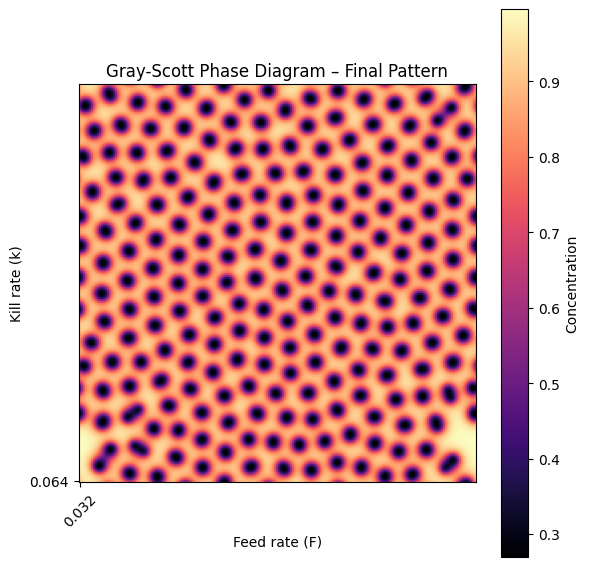

In [19]:
final_pattern_spots, out_file_name_spots = simulate_phase_diagram_movie(feed_rates=[0.032], kill_rates=[0.064],
                                 diffusion_u=0.16, diffusion_v=0.08,
                                 dt=1.0, total_time=8000.0,
                                 sample_interval=50, frame_store_interval=1,
                                 grid_size=200, num_perturbations=10,
                                 integration_method='euler',
                                 movie_filename='sample_simulation_spots.mp4', fps=60)

Simulating parameter grid: 100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


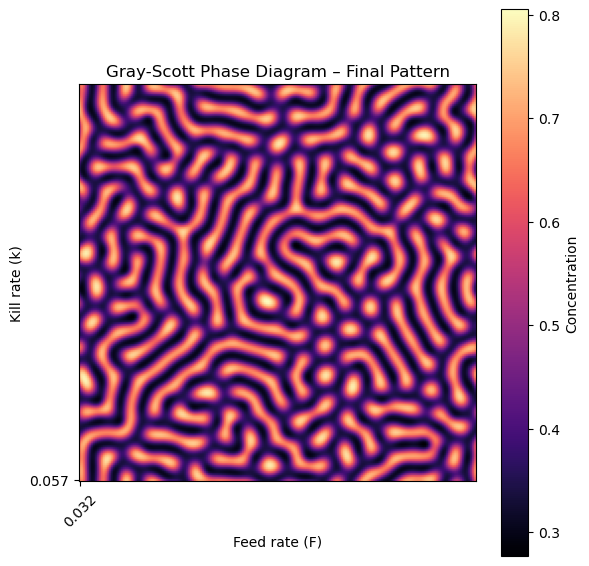

In [14]:
final_pattern_stripes, out_file_name_stripes = simulate_phase_diagram_movie(feed_rates=[0.032], kill_rates=[0.057],
                                 diffusion_u=0.16, diffusion_v=0.08,
                                 dt=1.0, total_time=4000.0,
                                 sample_interval=20, frame_store_interval=1,
                                 grid_size=200, num_perturbations=10,
                                 integration_method='euler',
                                 movie_filename='sample_simulation_stripes.mp4', fps=60)

Simulating parameter grid: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


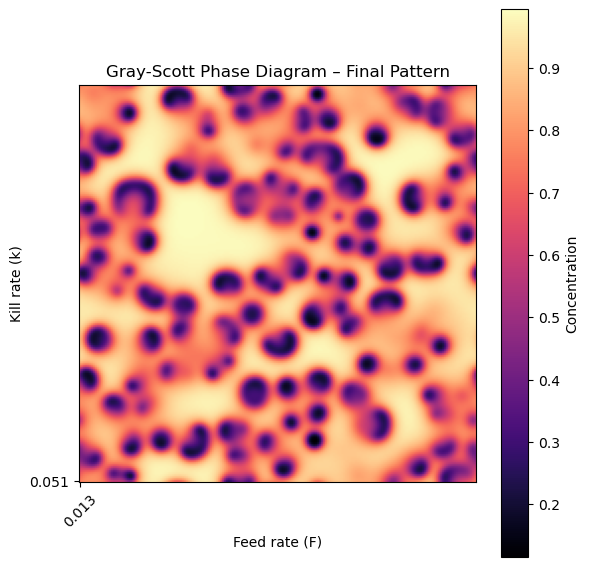

In [15]:
final_pattern_changing, out_file_name_changing = simulate_phase_diagram_movie(feed_rates=[0.013], kill_rates=[0.051],
                                 diffusion_u=0.16, diffusion_v=0.08,
                                 dt=1.0, total_time=10000.0,
                                 sample_interval=20, frame_store_interval=1,
                                 grid_size=200, num_perturbations=10,
                                 integration_method='euler',
                                 movie_filename='sample_simulation_changing.mp4', fps=60)

Simulating parameter grid: 100%|██████████| 400/400 [02:31<00:00,  2.63it/s]


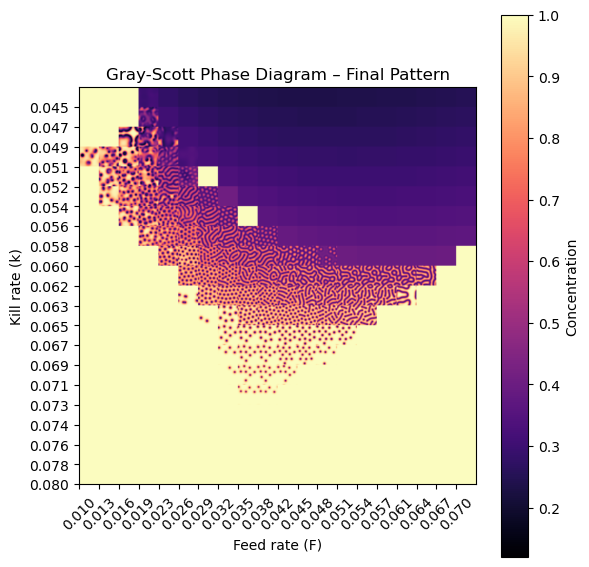

In [16]:
final_pattern_grid, out_file_name_grid = simulate_phase_diagram_movie(feed_rates=None, kill_rates=None,
                                 diffusion_u=0.16, diffusion_v=0.08,
                                 dt=1.0, total_time=7000.0,
                                 sample_interval=20, frame_store_interval=1,
                                 grid_size=64, num_perturbations=15,
                                 integration_method='euler',
                                 movie_filename='parameter_grid_simulation.mp4', fps=10)

### Quantitative analysis

#### Function
- extract_features
    - mean, standard deviation, horizontal gradient, vertical gradient, connected components, high frequency energy
- plot_quant_map
    - plot out quantitative map in parameter space of kill rate and feed rate
- test_parameter_robustness
    - change 1 paramters and keep all other parameters to test whether introduing noise to the parameter affect pattern formation

In [ ]:
def extract_features(img):
     
    mean = np.mean(img)
    std = np.std(img)
    entropy = shannon_entropy(img)
    x_edges = np.mean(sobel(img, axis=0)) # horizontal (x) gradient
    y_edges = np.mean(sobel(img, axis=1)) # vertical (y) gradient

    # connected components
    labeled = label(img > 0.5)
    n_components = labeled.max()

    # spectrum energy
    fft_img = np.abs(np.fft.fftshift(np.fft.fft2(img)))
    high_freq_energy = np.mean(fft_img[img.shape[0]//4:-img.shape[0]//4, img.shape[1]//4:-img.shape[1]//4])
    
    return [mean, std, entropy, x_edges, y_edges, n_components, high_freq_energy]

In [ ]:
def plot_quant_map(df_feature, value_col):

    feature_data = df_feature.pivot(index='k', columns='F', values=value_col)
    sns.heatmap(feature_data, cmap='viridis', annot=False)
    
    plt.xticks(ticks=np.arange(len(feature_data.columns)), labels=[f"{val:.3f}" for val in feature_data.columns])
    plt.yticks(ticks=np.arange(len(feature_data.index)), labels=[f"{val:.3f}" for val in feature_data.index])
    plt.xlabel('Feed rate (k)')
    plt.ylabel('Kill rate (F)')

In [45]:
def test_parameter_robustness(param_name, baseline, perturb_range, repeat):
    '''
    test the robustness of the pattern to perturbations in a parameter.
    Input:
    - param_name: the parameter to perturb
    - baseline: a dictionary of baseline parameters
    - perturb_range: a list of perturbation percentages
    - repeat: number of times to repeat the simulation
    Output:
    - plot of the average change in features as a function of perturbation
    '''
    deltas_repeat = []

    for i in range(repeat):

        params = baseline.copy()
        params['seed'] = baseline['seed']*(i+1)

        base_hist = run_simulation(**params)
        base_img = base_hist[-1]
        base_feat = extract_features(base_img)

        deltas = []

        for pct in perturb_range:
            perturbed = baseline.copy()
            perturbed[param_name] *= (1 + pct)
            perturbed['seed'] = params['seed']
            pert_hist = run_simulation(**perturbed)
            pert_img = pert_hist[-1]
            pert_feat = extract_features(pert_img)

            # using Euclidean distance between features
            delta = np.linalg.norm(np.array(base_feat) - np.array(pert_feat))
            deltas.append(delta)

        deltas_repeat.append(deltas)

    return deltas_repeat

In [42]:
def getpattern(param):
    '''
    Get the pattern of a parameter.
    Input:
    - param: a dictionary of parameters
    Output:
    - pattern: the pattern of the parameter
    '''
    patterns = run_simulation(**param)
    return patterns[-1]

#### Parameters set up

In [47]:
# list of feeding and killing rates
F_list = np.linspace(0.01, 0.07, 20)
k_list = np.linspace(0.045, 0.08, 20)

# baseline parameters other than feeding and killing rates
baseline_params = {
    'feed_rate': 0.032,
    'kill_rate': 0.057,
    'diffusion_u': 0.16,
    'diffusion_v': 0.08,
    'num_steps': 7000,
    'grid_size': 64,
    'sample_interval': 1,
    'num_perturbations': 15,
    'integration_method': 'euler',
    'dt': 1.0,
    'seed': 42
}

# list of features to extract
feature_names = ['Mean', 'Standard Deviation', 'Entropy', 'Horizontal Edge', 'Vertical Edge', 'Number of Components', 'Energy in High Frequencies']

#### Plot quantitative parameter map

In [48]:
features = []
kf_combinations = []

for i, F in enumerate(F_list):
    for j, k in enumerate(k_list):
        params = baseline_params.copy()
        params['feed_rate'] = F
        params['kill_rate'] = k

        patterns = run_simulation(**params)
        last_img = patterns[-1]

        feat = extract_features(last_img)

        features.append(feat)
        kf_combinations.append((F, k))

# package
df_features = pd.DataFrame(features, columns=feature_names)
df_features['F'] = [f for f, _ in kf_combinations]
df_features['k'] = [k for _, k in kf_combinations]

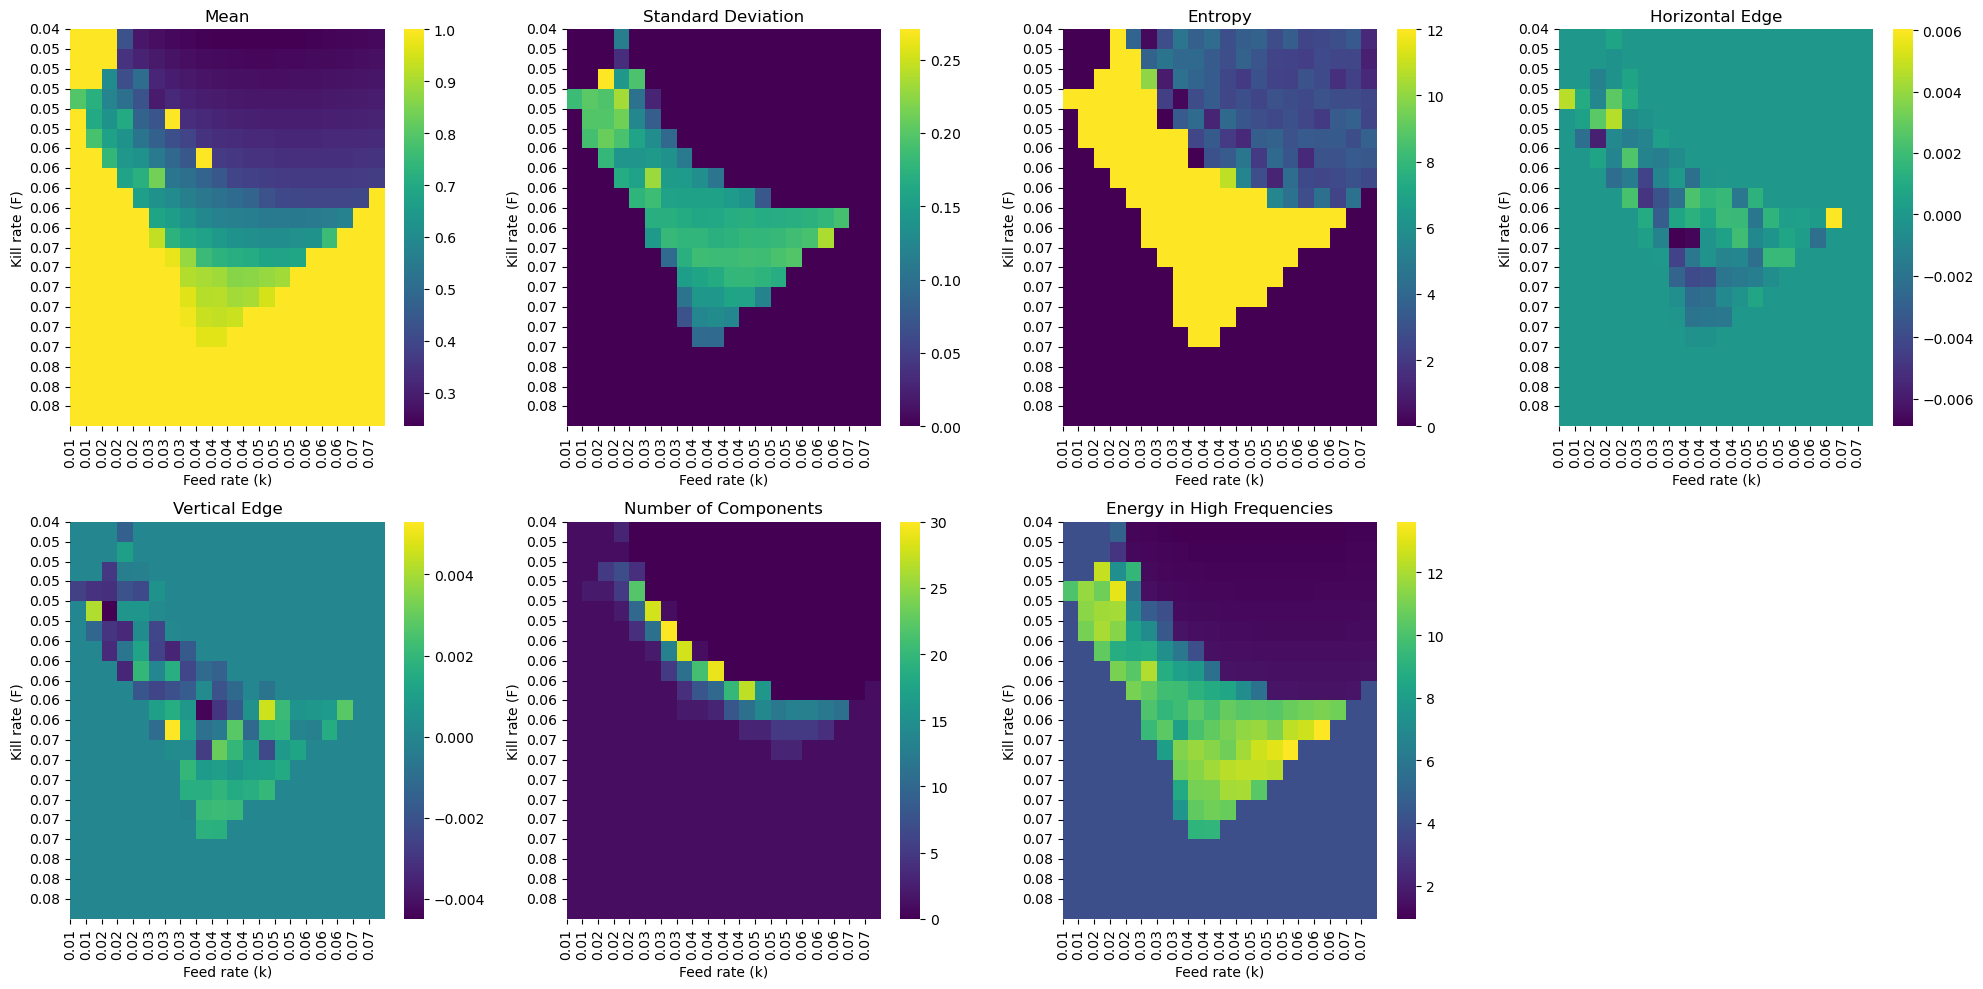

In [49]:
fig = plt.figure(figsize=(20, 10))

for i, feature in enumerate(feature_names):
    plt.subplot(2, 4, i + 1)
    plot_quant_map(df_features, feature)
    plt.title(f"{feature}")

plt.tight_layout()
plt.show()
    

#### Test robustness of parameters

In [50]:
repeat = 10

perturb_range = np.linspace(-0.1, 0.1, 9)

robustness = {}
for param_name in ['feed_rate', 'kill_rate', 'diffusion_u', 'diffusion_v']:
    if param_name not in robustness:
        robustness[param_name] = {}
    robustness[param_name] = test_parameter_robustness(param_name, baseline_params, perturb_range, repeat)

#### Visulization of pattern change under perturbation

Text(0.08, 0.5, 'Parameter')

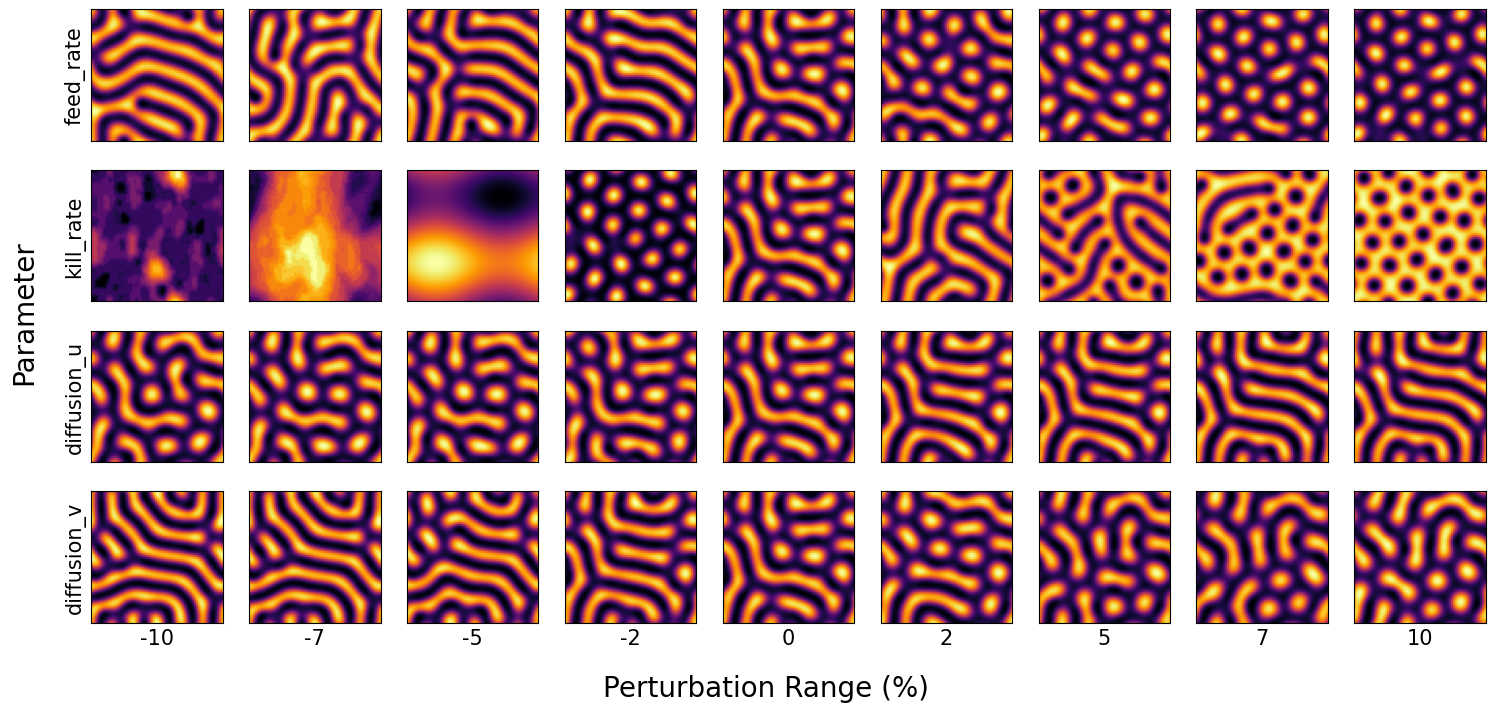

In [51]:
fig, axes = plt.subplots(4, len(perturb_range), figsize=(18, 8))

for row, param_name in enumerate(['feed_rate', 'kill_rate', 'diffusion_u', 'diffusion_v']):
    for col, perturb in enumerate(perturb_range):
        perturbed = baseline_params.copy()
        perturbed[param_name] *= (1 + perturb)
        pattern = getpattern(perturbed)

        ax = axes[row, col]
        ax.imshow(pattern, cmap='inferno')
        ax.set_yticks([])
        ax.set_xticks([])

        if row == 3:  # Last row
            ax.set_xlabel(f"{int(perturb*100)}", fontsize=15)
        if col == 0:  # First column
            ax.set_ylabel(param_name, fontsize=15)
        
# Set x-axis label for the entire figure
fig.text(0.5, 0.02, 'Perturbation Range (%)', ha='center',fontsize=20)

# Set y-axis label for the entire figure
fig.text(0.08, 0.5, 'Parameter', va='center', rotation='vertical',fontsize=20)


#### Plot trendency with parameter perturbation

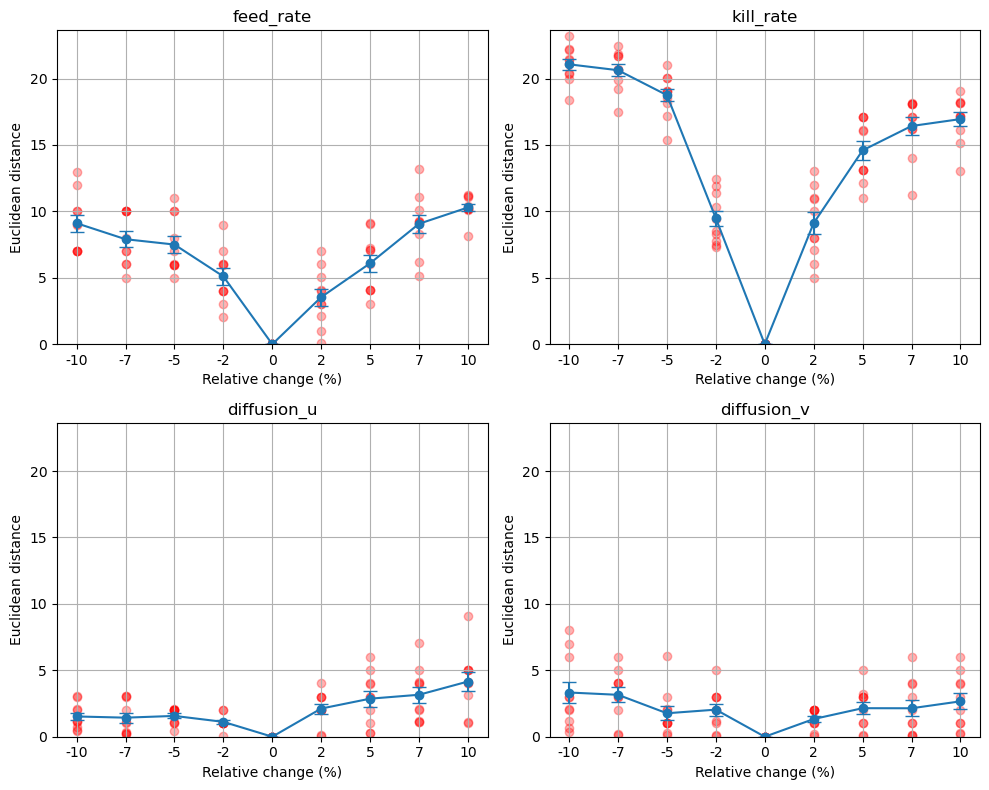

         feed_rate     kill_rate  diffusion_u  diffusion_v
-10%  3.381988e-07  3.293493e-12     0.000740     0.003840
-7%   4.771938e-07  7.338583e-12     0.005238     0.000555
-5%   1.394754e-06  3.455650e-11     0.000021     0.010624
-2%   2.767124e-05  7.474258e-08     0.000117     0.002312
0%             NaN           NaN          NaN          NaN
2%    5.756948e-04  1.878455e-06     0.000471     0.000432
5%    9.965075e-06  9.487624e-09     0.001287     0.002006
7%    4.982252e-07  2.392880e-09     0.000744     0.009000
10%   3.846937e-11  2.351332e-10     0.000268     0.002605


In [53]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, (param_name, deltas) in zip(axes.flatten(), robustness.items()):

    deltas = np.array(deltas)
    deltas_mean = np.mean(deltas, axis=0)
    deltas_std = np.std(deltas, axis=0) / np.sqrt(repeat)

    ax.errorbar(perturb_range, deltas_mean, yerr=deltas_std, marker='o', capsize=5)
    for deltas_per_repeat in deltas:
        ax.scatter(perturb_range, deltas_per_repeat, color='red', alpha=0.3)

    ax.set_title(f"{param_name}")
    ax.set_xticks(perturb_range)
    ax.set_xticklabels([int(x * 100) for x in perturb_range])
    ax.set_xlabel("Relative change (%)")
    ax.set_ylabel("Euclidean distance")

    ax.grid(True)
    ylim_max = np.max([np.max(np.mean(np.array(d), axis=0) + np.std(np.array(d), axis=0) / np.sqrt(repeat)) for d in robustness.values()]) * 1.1
    ax.set_ylim(0, ylim_max)

plt.tight_layout()
plt.show()

param_pvalue = {}
for param_name, deltas in robustness.items():
    deltas = np.array(deltas)
    p_values = []
    for i in range(len(perturb_range)):
        _, p_value = ttest_ind(deltas[:, i], deltas[:, 4], equal_var=False)
        
        p_values.append(p_value)
    param_pvalue[param_name] = p_values

# Organize p-values into a DataFrame with perturb_range as rows and param_name as columns
df_p_values = pd.DataFrame(param_pvalue, index=[f"{int(x * 100)}%" for x in perturb_range])

# Save the DataFrame to a CSV file
df_p_values.to_csv("p_values_robustness.csv", index_label="Perturbation")

# Display the DataFrame
print(df_p_values)
